In [241]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

from scipy.linalg import orth
from numpy.linalg import eig

%matplotlib inline

In [2]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

## Probabilistic Distillation of Neural Networks
#### by [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/) 

Neural network distillation [(Ba and Caruana, 2013)](https://arxiv.org/abs/1312.6184) [(Hinton et al., 2015)](https://arxiv.org/abs/1503.02531) [(Balan et al., 2015)](http://papers.nips.cc/paper/5965-bayesian-dark-knowledge)---where the probabilities produced by a large 'teacher' model are used as targets for training a smaller 'student' model---is crucial for delopying neural networks to systems for which runtime and memory are limited.  This notebook proposes a new strategy for *probabilistic* distillation, providing a distribution over various simpler models.  Moreover, the proposed method has the benefits that (1) the student model does not need its own optimization loop and (2) as the students are mixtures of linear models, they allow for a high degree of interpretability.    

### 1.  Linearizing Neural Networks
Before introducing our novel method, we review a technique proposed by [Wang et al. (ICML 2016)](http://proceedings.mlr.press/v48/wanga16.pdf) for linearizing deep neural networks.  Assume we have a trained neural network with ReLU activations.  For a given datapoint $\mathbf{x}_{i}$, we begin its propagation through the network by computing the first hidden states as $\mathbf{h}_{i,1} = \text{ReLU}(\mathbf{x}_{i} \mathbf{W}_{1})$.  Yet, notice that for any hidden state $h_{i,1,j} = 0$, we could achive the same $\mathbf{h}_{i,1}$ by setting the $j$th column of $\mathbf{W}_{1}$ to all zeros.  The ReLU function would then be superflous, and the hidden units could be expressed simply as a multiplication, i.e. $\mathbf{h}_{i,1} = \mathbf{x}_{i} \tilde{\mathbf{W}}_{1}$ where $\tilde{\mathbf{W}}_{1}$ is $\mathbf{W}_{1}$ but with the appropriate columns masked to zero.  Repeating this process for all layers in the network, we get a composition of linear transformations, which is itself linear: $$ \mathbf{o}_{i} \ \ = \ \ \mathbf{x}_{i} \tilde{\mathbf{W}}_{1} \tilde{\mathbf{W}}_{2} \ldots \mathbf{W}_{L} \ \ = \ \ \mathbf{x}_{i} \tilde{\mathbf{U}}_{i}$$ where $\mathbf{o}_{i}$ is the final output pre-activation (i.e. $\mathbf{\hat{y}}_{i} = f_{out}(\mathbf{o}_{i})$) and $\tilde{\mathbf{U}}_{i}$ is the product of all masked linear transformations.  Interestingly, $\tilde{\mathbf{U}}_{i}$ is equivalent to the output gradient taken w.r.t. the input: $$ \frac{\partial \mathbf{o}_{i}}{\partial \mathbf{x}_{i}} \  = \  \frac{\partial \mathbf{o}_{i}}{\partial \mathbf{h}_{i, L}} \  \frac{\partial \mathbf{h}_{i,L}}{\partial \mathbf{h}_{i, L-1}} \ldots \frac{\partial \mathbf{h}_{i,2}}{\partial \mathbf{h}_{i, 1}} \ \frac{\partial \mathbf{h}_{i,1}}{\partial \mathbf{x}_{i}} \ = \ \mathbf{W}_{L}\tilde{\mathbf{W}}_{L-1}\ldots\tilde{\mathbf{W}}_{1} \ = \ \tilde{\mathbf{U}}_{i}^{T}. $$  Furthermore, this equivalence holds for convolutional networks with ReLU activations and max or average pooling.       

Collecting all $\tilde{\mathbf{U}}_{i}$'s across the training set, we can write the whole neural network as piecewise linear function---or in other words, a mixture of $N$ linear experts, one for each training datapoint: $$ f(\mathbf{x}; \{ \tilde{\mathbf{U}}_{1}, \tilde{\mathbf{U}}_{2}, \ldots, \tilde{\mathbf{U}}_{N} \}) = \sum_{i=1}^{N} \pi_{i}(\mathbf{x}) \ \mathbf{x}  \tilde{\mathbf{U}}_{i}  \ \ \ \text{where} \ \ \ \pi_{i}(\mathbf{x}) = \frac{k(\mathbf{x}, \mathbf{x}_{i}; \beta)}{\sum_{j=1}^{N} k(\mathbf{x}, \mathbf{x}_{j}; \beta)}$$ where $\pi_{i}(\mathbf{x})$ is a gating function comprised of kernels and $\beta$ is a scale parameter for the kernels.  Notice that sending $\beta \rightarrow 0$ results in $\pi(\cdot)$ becoming a hard assignment and thus allows the mixture to produce exactly the same output on the training set as the original model.  

####  Experiment: Regression Simulation

Let's now demonstrate how to find the mixture of experts representation a network trained on one-dimensional data...

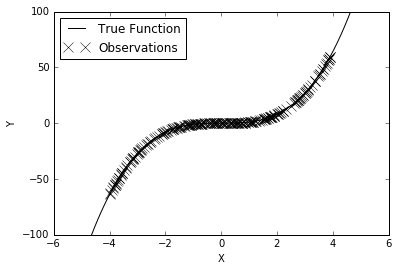

In [311]:
# Simulate N observations from a cubic function
N = 250
x = np.array([np.random.uniform(-4,4) for n in range(N)])[np.newaxis].T
y = x**3

# True function
x_true = np.linspace(start=-6, stop=6, num=100)
y_true = x_true**3

plt.plot(x_true, y_true, 'k-', label="True Function")
plt.plot(x, y, 'xk', ms=10, linewidth=1, label="Observations")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

Next let's define the model: a one-hidden-layer neural network with 50 units...

In [312]:
# Regression NN with one hidden layer of 50 units
def logModel(W, b, x, y):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    y_hat = np.dot(h, W[:, 50:].T) + b[:, 50:]
    return np.sum( .5 * -(y - y_hat)**2 )

def fprop(W, b, x):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    return np.dot(h, W[:, 50:].T) + b[:, 50:]


### GET DERIVATIVES ###
# d log p(X | \theta) / d \theta
dLogModel_dW = grad(logModel)
dLogModel_db = grad(lambda b, W, x, y: logModel(W, b, x, y))

Now let's train the NN...

In [313]:
### INIT PARAMS 
theta = {'W': .001 * np.random.normal(size=(1,100)), 'b': np.zeros((1,51))}

### ELBO OPTIMIZATION
maxEpochs = 1000
learning_rate = .01
adam_values = {'W':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

loss = 0.
for epochIdx in range(maxEpochs):
    
    dModel_dW = dLogModel_dW(theta['W'], theta['b'], x, y) 
    dModel_db = dLogModel_db(theta['b'], theta['W'], x, y)
        
    theta['W'] += get_AdaM_update(learning_rate, dModel_dW, adam_values['W'])  
    theta['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b'])
    
    loss += logModel(theta['W'], theta['b'], x, y)
    if (epochIdx+1) % 100 == 0:
        print "%d. Neg. Log Likelihood: %.3f" %(epochIdx+1, -loss/5.)
        loss = 0.

100. Neg. Log Likelihood: 795343.742
200. Neg. Log Likelihood: 281304.128
300. Neg. Log Likelihood: 152847.191
400. Neg. Log Likelihood: 74111.088
500. Neg. Log Likelihood: 38944.885
600. Neg. Log Likelihood: 25161.689
700. Neg. Log Likelihood: 17686.965
800. Neg. Log Likelihood: 11945.767
900. Neg. Log Likelihood: 8247.650
1000. Neg. Log Likelihood: 5560.087


And visualize the results...

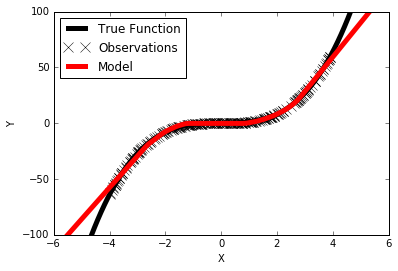

In [314]:
plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x, y, 'xk', ms=10, linewidth=1, label="Observations")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=5, label="Model")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### Linearizing the Network

Next let's write a function that extracts $\tilde{\mathbf{U}}_{i}$ for each $\mathbf{x}_{i}$...

In [322]:
def get_linear_transform(x_i, W, b):
    #copy
    W_tilde = np.array(W)
    b_tilde = np.array(b)
    
    # fprop
    h = np.maximum(np.dot(x_i, W[:, :50]) + b[:, :50], 0.)
    
    # apply mask
    for j in range(50):
        if h[0, j] == 0: 
            W_tilde[:, j] = 0.
            b_tilde[:, j] = 0.
            
    # construct matrices
    W1_tilde = np.vstack([W_tilde[:, :50], b_tilde[:, :50]]) #add bias
    next_bias = np.hstack([1./x_i, np.zeros((1,1))]).T
    W1_tilde = np.hstack([W1_tilde, next_bias]) # add bias for next layer
    
    W2_tilde = np.vstack([W_tilde[:, 50:].T, b_tilde[:, 50:]]) #add bias
    
    return np.dot(W1_tilde, W2_tilde)

Next we calculate all the $\tilde{\mathbf{U}}$ vectors...

In [329]:
x = np.sort(x, axis=0)

U_vectors = []
for i in range(N):
    U_vectors.append( get_linear_transform(x[i,:][np.newaxis], theta['W'], theta['b'])[:,0] )
U_vectors = np.array(U_vectors).T

Define a kernel function and calculate it between all pairs...

In [330]:
def kernel(x1, x2, beta=.0001):
    #if x1[0] == x2[0]: return 1.
    #return 0
    return np.exp(-np.sum((x1-x2)**2)/beta)

kernel_vals = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        kernel_vals[i,j] = kernel(x[i], x[j])
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

#### Training Data Result

Visualize the result on the training data..

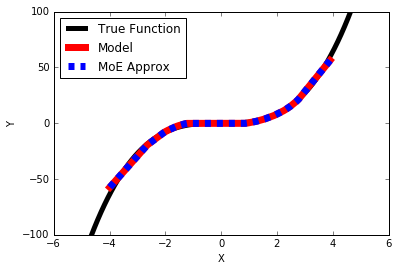

In [331]:
x_w_bias = np.hstack([x, np.ones((N,1))])
yHat_MoE = np.sum(np.dot(x_w_bias, U_vectors) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x, fprop(theta['W'], theta['b'], x), 'r-', linewidth=7, label="Model")
plt.plot(x, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### Test Data Result

Visualize the result for the true function...

In [332]:
kernel_vals = np.zeros((100, N))
beta_val = .1

for i in range(100):
    for j in range(N):
        kernel_vals[i,j] = kernel(x_true[i], x[j], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

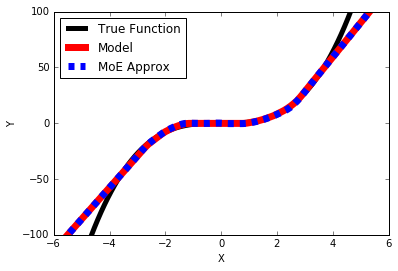

In [333]:
xTrue_w_bias = np.hstack([x_true[np.newaxis].T, np.ones((100,1))])
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_vectors) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

### 2.  Reducing the Number of Experts 
Using the above mixture of experts representation in place of the original model requires $\mathcal{O}(Nd)$ time, as it depends on the number of training points, which is a dependence we'd like to break.  Hence, we would like form a good approximation using only a subset of the experts: $$ f(\mathbf{x}; \{ \tilde{\mathbf{U}}_{1}, \tilde{\mathbf{U}}_{2}, \ldots, \tilde{\mathbf{U}}_{N} \}) \  \approx  \  \sum_{k=1}^{K} \pi_{k}(\mathbf{x}) \ \mathbf{x}  \tilde{\mathbf{U}}_{k}$$ for $K<<N$.  How should we choose the subset?  Below we attempt several different strategies...

#### A.  Random Sampling
We start with a naive solution: random sampling.  We sample $K$ pairs $\{\mathbf{x}_{k}, \tilde{\mathbf{U}}_{k} \}$ without replacement from the set of $N$.     

In [427]:
K = 4
k_idxs = np.random.choice(N, K)

kernel_vals = np.zeros((100, K))
beta_val = .1

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

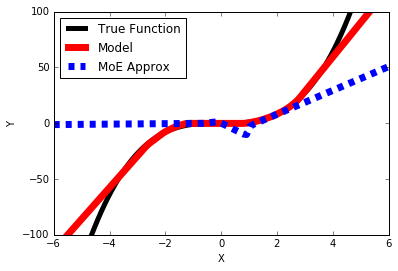

In [428]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### B.  Regular Sampling
We continue with another naive solution: sampling regular interval.  We sample $K$ pairs $\{\mathbf{x}_{k}, \tilde{\mathbf{U}}_{k} \}$ by choosing every $N/k$th ordered point.     

In [429]:
K = 4
k_idxs = [0] + [k * N/(K-1) for k in range(1, K-1)] + [N-1]
print k_idxs

kernel_vals = np.zeros((100, K))
beta_val = .1

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

[0, 83, 166, 249]


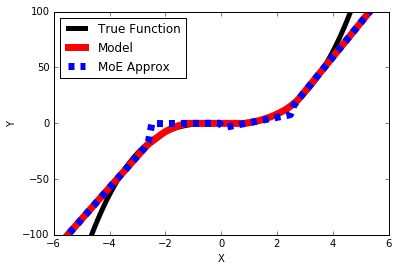

In [430]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### C.   Douglas-Peucker Algorithm
For polylines, there is a recursive simplification algorithm known as the [Douglas-Peucker Algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm).  It has an expected runtime of $\mathcal{O}(N \log N)$.     

In [420]:
import math
import time


def timenow():
    return int(time.time() * 1000)

def sqr(x):
    return x*x

def distSquared(p1, p2):
    return sqr(p1[0] - p2[0]) + sqr(p1[1] - p2[1])

class Line(object):
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        self.lengthSquared = distSquared(self.p1, self.p2)

    def getRatio(self, point):
        segmentLength = self.lengthSquared
        if segmentLength == 0:
            return distSquared(point, p1);
        return ((point[0] - self.p1[0]) * (self.p2[0] - self.p1[0]) + \
        (point[1] - self.p1[1]) * (self.p2[1] - self.p1[1])) / segmentLength

    def distanceToSquared(self, point):
        t = self.getRatio(point)

        if t < 0:
            return distSquared(point, self.p1)
        if t > 1:
            return distSquared(point, self.p2)

        return distSquared(point, [
            self.p1[0] + t * (self.p2[0] - self.p1[0]),
            self.p1[1] + t * (self.p2[1] - self.p1[1])
        ])

    def distanceTo(self, point):
        return math.sqrt(self.distanceToSquared(point))


def simplifyDouglasPeucker(points, pointsToKeep):
    weights = []
    length = len(points)

    def douglasPeucker(start, end):
        if (end > start + 1):
            line = Line(points[start], points[end])
            maxDist = -1
            maxDistIndex = 0

            for i in range(start + 1, end):
                dist = line.distanceToSquared(points[i])
                if dist > maxDist:
                    maxDist = dist
                    maxDistIndex = i

            weights.insert(maxDistIndex, maxDist)

            douglasPeucker(start, maxDistIndex)
            douglasPeucker(maxDistIndex, end)

    douglasPeucker(0, length - 1)
    weights.insert(0, float("inf"))
    weights.append(float("inf"))

    weightsDescending = weights
    weightsDescending = sorted(weightsDescending, reverse=True)

    maxTolerance = weightsDescending[pointsToKeep - 1]
    result = [
        point for i, point in enumerate(points) if weights[i] >= maxTolerance
    ]

    return result

In [425]:
K = 4
point_tups = zip(x[:,0].tolist(), fprop(theta['W'], theta['b'], x)[:,0].tolist())
points_kept = simplifyDouglasPeucker(points=point_tups, pointsToKeep=K)
k_idxs = [point_tups.index(p) for p in points_kept]

kernel_vals = np.zeros((100, K))
beta_val = 1.

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

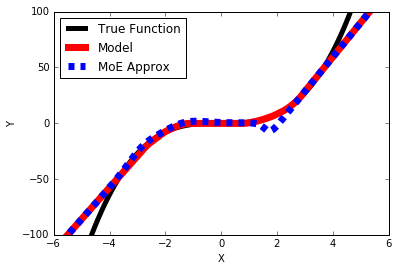

In [426]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### B.  DPP Sampling

*volume sampling* [(Derezinski and Warmuth, NIPS 2017)](https://arxiv.org/abs/1705.06908): we choose the $K$ vectors based on the resulting volume of their inclosing parallelepiped.  This is equivalent to sampling the set from a [fixed-sized determinantal point process](https://homes.cs.washington.edu/~taskar/pubs/kdpps_icml11.pdf).  

In [302]:
def elem_sympoly(vals, k):
    """Uses Newton's identities to compute elementary symmetric polynomials."""
    N = vals.shape[0]
    E = np.zeros([k+1, N+1])
    E[0,] = 1
    
    for i in range(1, k+1):
        for j in range(1, N+1):
            E[i,j] = E[i, j-1] + vals[j-1] * E[i-1, j-1]
    
    return E[:,1:]

def sample_k(vals, k):
    """
    """
    N = vals.shape[0]
    E = elem_sympoly(vals, k)[:,1:]
    sample = np.zeros(N, dtype=int)
    rem = k

    for elem, val in reversed(list(enumerate(vals))):

        # Check if we chose k elements
        if not rem:
            break
            
        # Compute conditional marginal of elem
        marg = val * E[rem-1, elem-1] / E[rem, elem]

        # Sample elem
        if np.random.rand() < marg:
            sample[elem] = 1
            rem -= 1
        
        # Check if all remaining elements will be chosen
        if elem == rem:
            sample[np.arange(rem)] = 1
            break

    return sample

def sample_from_dpp(item_vectors, k=None):
    """
    This function expects 
    
    Arguments: 
    vals: NumPy 1D Array of Eigenvalues of Kernel Matrix
    vecs: Numpy 2D Array of Eigenvectors of Kernel Matrix
    """
    n = item_vectors.shape[0] # number of items in ground set
    gram_mat = np.dot(item_vectors, item_vectors.T)
    vals, vecs = eig(gram_mat)
    
    # k-DPP
    if k > 0:
        index = sample_k(vals, k) # sample_k, need to return index

    # Sample set size
    else:
        index = (np.random.rand(n) < (vals / (vals + 1)))
        k = np.sum(index)
    
    # Check for empty set
    if k == 0:
        return [] #np.empty(0)
    
    # Check for full set
    if k == n:
        return np.arange(k, dtype=float) 
    
    V = vecs[:, index]

    # Sample a set of k items 
    items = list()

    for i in range(k):
        p = np.sum(V**2, axis=1)
        p = np.cumsum(p / np.sum(p)) # item cumulative probabilities
        item = (np.random.rand() <= p).argmax()
        items.append(item)
        
        # Delete one eigenvector not orthogonal to e_item and find new basis
        j = (np.abs(V[item, :]) > 0).argmax() 
        Vj = V[:, j]
        V = orth(V - (np.outer(Vj,(V[item, :] / Vj[item])))) 
    
    items.sort()
    sample = items #np.array(items, dtype=float)    
    
    return sample 

In [308]:
x_sample_idxs = sample_from_dpp(x, k=0)
x_sample_vectors = x[x_sample_idxs, :]
U_vecs_sample = U_vectors[:, x_sample_idxs]
samp_size = len(x_sample_idxs)

print x_sample_idxs

[211]


In [309]:
kernel_vals = np.zeros((100, samp_size))
beta_val = .1

for i in range(100):
    for j, j_idx in enumerate(x_sample_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[j_idx], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


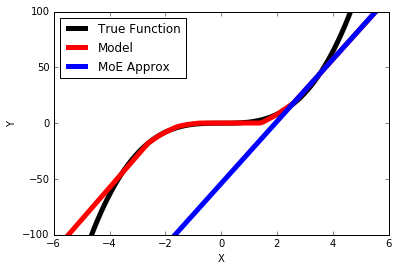

In [310]:
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_vecs_sample) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=5, label="Model")
plt.plot(x_true, yHat_MoE, 'b-', linewidth=5, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()